# **Part1: Diffusion Models and Latent Diffusion**



In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # 只使用第3号 GPU

import torch
print("Using GPU:", torch.cuda.get_device_name(0))


Fri Oct 24 17:16:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.169                Driver Version: 570.169        CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:21:00.0 Off |                  Off |
| 46%   33C    P8             29W /  450W |   44802MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import numpy
import pandas
from datasets import load_dataset

print("numpy:", numpy.__version__)
print("pandas:", pandas.__version__)
print("datasets:", __import__('datasets').__version__)


numpy: 1.23.5
pandas: 2.2.2
datasets: 4.2.0


In [3]:
# ----------------------
import numpy as np
import random
def set_seed(seed=42):
    """设置所有随机种子以保证可复现性"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"✅ Random seed set to {seed}")

# ----------------------
# User config
# ----------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
SEED = 42
set_seed(SEED)

✅ Random seed set to 42


In [ ]:
# improved_ddim_train_with_DiT.py
"""
Training script (DiT or UNet fallback) using DDIM instead of DDPM.
"""

import os
import copy
import json
import time
import random
from pathlib import Path
from tqdm import tqdm
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid, save_image
from PIL import Image

# ---------------------- Try importing DiT / fallback UNet ----------------------
USE_DIT = True
DIT_MODEL_ID = "facebook/DiT-XL-2-256"
try:
    from diffusers import DiTModel, DDIMScheduler  # ✅ use DDIMScheduler instead of DDPM
    print("Using DiT + DDIMScheduler")
except Exception as e:
    print("DiT unavailable, fallback to UNet. Error:", e)
    USE_DIT = False
    from diffusers import UNet2DModel, DDIMScheduler  # ✅ fallback also uses DDIM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# ---------------------- Config ----------------------
train_raw_path = "/tiny-imagenet/train"
val_raw_path   = "/tiny-imagenet/valid"
save_dir = "tinyimagenet_ddim_dit"
os.makedirs(save_dir, exist_ok=True)

batch_size = 64
num_workers = 4
epochs = 50
lr = 1e-4
weight_decay = 1e-4
gradient_clip = 1.0

num_train_timesteps = 1000
beta_schedule = "squaredcos_cap_v2"
use_ema = True
ema_decay = 0.9999
ema_update_every = 1
sample_batch = 8
sample_every_epochs = 5
sample_steps_for_infer = 100  # ✅ DDIM可少步生成

# ---------------------- Data ----------------------
normalize_mean = (0.5, 0.5, 0.5)
normalize_std  = (0.5, 0.5, 0.5)

img_transform = transforms.Compose([
    transforms.Lambda(lambda img: Image.fromarray(img) if isinstance(img, np.ndarray) else img),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(normalize_mean, normalize_std),
])

class GenericImageDataset(Dataset):
    def __init__(self, raw_dataset, transforms=None, image_field="image"):
        self.dataset = raw_dataset
        self.transforms = transforms
        self.image_field = image_field

    def __len__(self): return len(self.dataset)

    def __getitem__(self, idx):
        rec = self.dataset[idx]
        img = rec[self.image_field] if self.image_field in rec else rec.get("img", rec.get("image", None))
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img)
        if self.transforms:
            img = self.transforms(img)
        label = rec.get("label", -1)
        return img, int(label)

try:
    from datasets import load_dataset
    print("Loading tiny-imagenet...")
    train_raw = load_dataset("./tiny-imagenet", split="train")
    val_raw = load_dataset("./tiny-imagenet", split="valid")
    _train_ds = GenericImageDataset(train_raw, transforms=img_transform)
    _val_ds = GenericImageDataset(val_raw, transforms=img_transform)
except Exception as e:
    raise RuntimeError("Dataset load failed:", e)

train_loader = DataLoader(_train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(_val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

# ---------------------- Model ----------------------
if USE_DIT:
    try:
        print(f"Loading pretrained DiT: {DIT_MODEL_ID}")
        model = DiTModel.from_pretrained(DIT_MODEL_ID).to(device)
    except Exception as e:
        print("Fallback UNet due to DiT load error:", e)
        from diffusers import UNet2DModel
        model = UNet2DModel(
            sample_size=32, in_channels=3, out_channels=3,
            layers_per_block=2,
            block_out_channels=(64,128,256,256),
            down_block_types=("DownBlock2D","AttnDownBlock2D","AttnDownBlock2D","DownBlock2D"),
            up_block_types=("UpBlock2D","AttnUpBlock2D","AttnUpBlock2D","UpBlock2D")
        ).to(device)
else:
    from diffusers import UNet2DModel
    model = UNet2DModel(
        sample_size=32, in_channels=3, out_channels=3,
        layers_per_block=2,
        block_out_channels=(64,128,256,256),
        down_block_types=("DownBlock2D","AttnDownBlock2D","AttnDownBlock2D","DownBlock2D"),
        up_block_types=("UpBlock2D","AttnUpBlock2D","AttnUpBlock2D","UpBlock2D")
    ).to(device)

# ✅ Use DDIMScheduler
noise_scheduler = DDIMScheduler(
    num_train_timesteps=num_train_timesteps,
    beta_schedule=beta_schedule,
    clip_sample=True
)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# ---------------------- EMA ----------------------
if use_ema:
    ema_model = copy.deepcopy(model).to(device)
    for p in ema_model.parameters():
        p.requires_grad_(False)

def update_ema(ema_model, model, decay):
    with torch.no_grad():
        msd = model.state_dict()
        for k, v in ema_model.state_dict().items():
            if k in msd:
                v.copy_(v * decay + msd[k].to(v.device) * (1 - decay))

# ---------------------- Sampling ----------------------
def sample_and_save(model_for_sampling, scheduler, device, out_path, n_samples=8, steps=None, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    model_for_sampling.eval()
    if steps is None:
        steps = scheduler.num_train_timesteps

    # 初始化随机噪声
    x = torch.randn((n_samples, 3, 32, 32), device=device)

    # ✅ 设置 timesteps 和加噪/采样步数一致
    scheduler.set_timesteps(steps)

    with torch.no_grad():
        for t in tqdm(scheduler.timesteps, desc="DDIM sampling", leave=False):
            t_tensor = torch.full((n_samples,), int(t.item()), device=device, dtype=torch.long)
            out = model_for_sampling(x, t_tensor)
            noise_pred = out.sample if hasattr(out, "sample") else out

            # ✅ eta=0 确定性采样
            step_output = scheduler.step(
                model_output=noise_pred,
                timestep=int(t.item()),
                sample=x,
                eta=0.0
            )
            x = step_output.prev_sample

    # 转换为 [0,1] 图像
    x = (x.clamp(-1, 1) + 1) / 2.0
    grid = make_grid(x.cpu(), nrow=n_samples)
    save_image(grid, out_path)
    return out_path


# ---------------------- Training ----------------------
best_val_loss = float("inf")
log = []
global_step = 0

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
    for imgs, _ in pbar:
        imgs = imgs.to(device)
        bsz = imgs.size(0)
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=device).long()
        noise = torch.randn_like(imgs)
        noisy_images = noise_scheduler.add_noise(imgs, noise, timesteps)
        out = model(noisy_images, timesteps)
        noise_pred = out.sample if hasattr(out, "sample") else out
        loss = F.mse_loss(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        if gradient_clip: torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        optimizer.step()
        if use_ema and (global_step % ema_update_every == 0):
            update_ema(ema_model, model, ema_decay)
        running_loss += loss.item() * bsz
        global_step += 1
        pbar.set_postfix(loss=f"{loss.item():.5f}")

    avg_train_loss = running_loss / len(_train_ds)
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for imgs, _ in val_loader:
            imgs = imgs.to(device)
            bsz = imgs.size(0)
            t = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=device).long()
            n = torch.randn_like(imgs)
            noisy = noise_scheduler.add_noise(imgs, n, t)
            out = model(noisy, t)
            n_pred = out.sample if hasattr(out, "sample") else out
            val_loss += F.mse_loss(n_pred, n).item() * bsz
    avg_val_loss = val_loss / len(_val_ds)
    print(f"Epoch {epoch}: train={avg_train_loss:.5f}, val={avg_val_loss:.5f}")

    log.append({"epoch": epoch, "train": avg_train_loss, "val": avg_val_loss})
    json.dump(log, open(os.path.join(save_dir, "training_log.json"), "w"), indent=2)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), os.path.join(save_dir, "best_model_raw.pt"))
        if use_ema:
            torch.save(ema_model.state_dict(), os.path.join(save_dir, "best_model_ema.pt"))
        print(f"Saved best model (val={best_val_loss:.5f})")

    if epoch % sample_every_epochs == 0:
        sm = ema_model if use_ema else model
        out_path = os.path.join(save_dir, f"sample_epoch{epoch}.png")
        sample_and_save(sm, noise_scheduler, device, out_path, n_samples=sample_batch, steps=sample_steps_for_infer)
        print("Saved sample to", out_path)


DiT unavailable, fallback to UNet. Error: cannot import name 'DiTModel' from 'diffusers' (/home/congjy/anaconda3/envs/edm/lib/python3.9/site-packages/diffusers/__init__.py)
Device: cuda
Loading tiny-imagenet...


TypeError: __init__() got an unexpected keyword argument 'eta'

torch.Size([8, 3, 32, 32])
torch.Size([8, 3, 32, 32])


/tmp/ipykernel_1594493/3430756952.py:56: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1594493/3430756952.py:56: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1594493/3430756952.py:56: UserWarning: Glyph 21152 (\N{CJK UNIFIED IDEOGRAPH-52A0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1594493/3430756952.py:56: UserWarning: Glyph 22122 (\N{CJK UNIFIED IDEOGRAPH-566A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1594493/3430756952.py:56: UserWarning: Glyph 21453 (\N{CJK UNIFIED IDEOGRAPH-53CD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1594493/3430756952.py:56: UserWarning: Glyph 21521 (\N{CJK UNIFIED IDEOGRAPH-5411}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1594493/3430756952.py:56: UserWarning: Glyph 36824 (\N{CJK UN

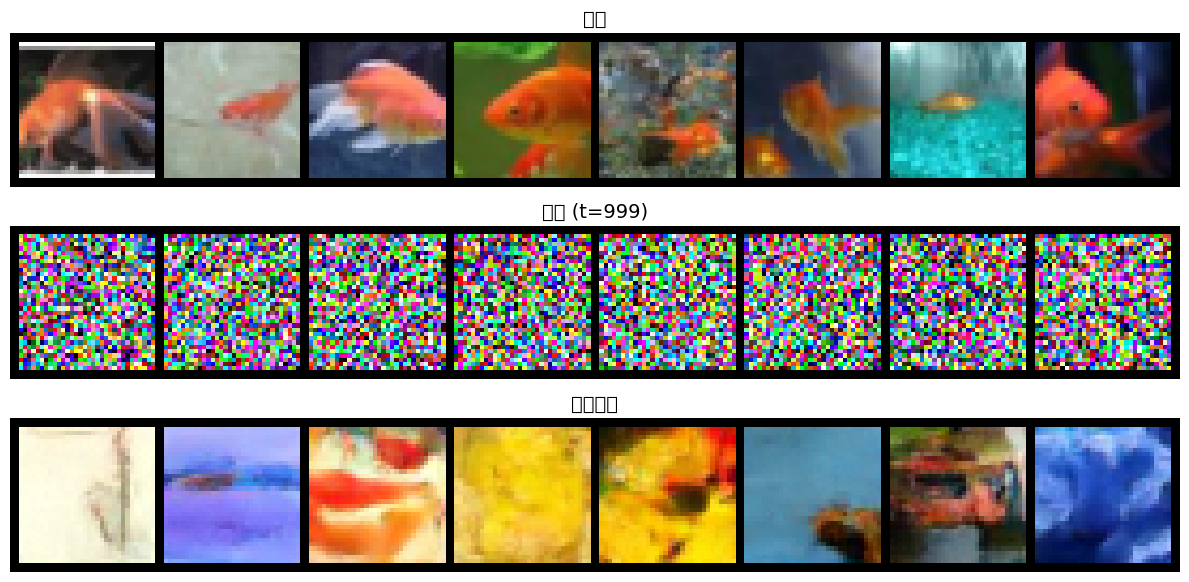

In [5]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

# === 1. 设置扩散时间步 ===
T = 500 

# === 2. 加载模型 ===
model.load_state_dict(torch.load("tinyimagenet_ddpm_32/best_model.pt", map_location="cpu"))
model = model.to(device)
model.eval()


# === 3. 可视化列 ===
cols = ["原图", f"加噪 (t={T})", "反向还原"]

# === 4. 取验证集前8张图片 ===
num_samples = 8
samples = [val_dataset[i][0] for i in range(num_samples)]
x0 = torch.stack(samples).to(device)

# === 5. 加噪 ===
t = torch.tensor([T] * num_samples, device=device)
noise = torch.randn_like(x0)
noisy = noise_scheduler.add_noise(x0, noise, t)

# === 6. 反向还原 ===
x = noisy.clone()
model.eval()
with torch.no_grad():
    for step in range(T, 0, -1):  # ✅ 循环上限同步使用 T
        t_step = torch.tensor(step, device=device)
        noise_pred = model(x, t_step).sample
        x = noise_scheduler.step(noise_pred, t_step, x).prev_sample

# === 7. 转换为可视化格式 ===
def to_img(x):
    x = (x.clamp(-1, 1) + 1) / 2  # [-1,1] → [0,1]
    return x

x0_vis = to_img(x0).cpu()
print(x0_vis.shape)
noisy_vis = to_img(noisy).cpu()
x_recon_vis = to_img(x).cpu()
print(x_recon_vis.shape)
# === 8. 拼接显示 ===
fig, axes = plt.subplots(3, 1, figsize=(12, 6))
images = [x0_vis, noisy_vis, x_recon_vis]

for ax, imgs, title in zip(axes, images, cols):
    grid = make_grid(imgs, nrow=num_samples)
    ax.imshow(grid.permute(1, 2, 0))
    ax.axis("off")
    ax.set_title(title, fontsize=14)

plt.tight_layout()
plt.show()


✅ 模型已成功加载（来自 Tiny-ImageNet 训练）。


/tmp/ipykernel_2095421/1510053547.py:123: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2095421/1510053547.py:123: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2095421/1510053547.py:123: UserWarning: Glyph 21152 (\N{CJK UNIFIED IDEOGRAPH-52A0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2095421/1510053547.py:123: UserWarning: Glyph 22122 (\N{CJK UNIFIED IDEOGRAPH-566A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2095421/1510053547.py:123: UserWarning: Glyph 21453 (\N{CJK UNIFIED IDEOGRAPH-53CD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2095421/1510053547.py:123: UserWarning: Glyph 21521 (\N{CJK UNIFIED IDEOGRAPH-5411}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2095421/1510053547.py:123: UserWarning: Glyph 36824 (\N

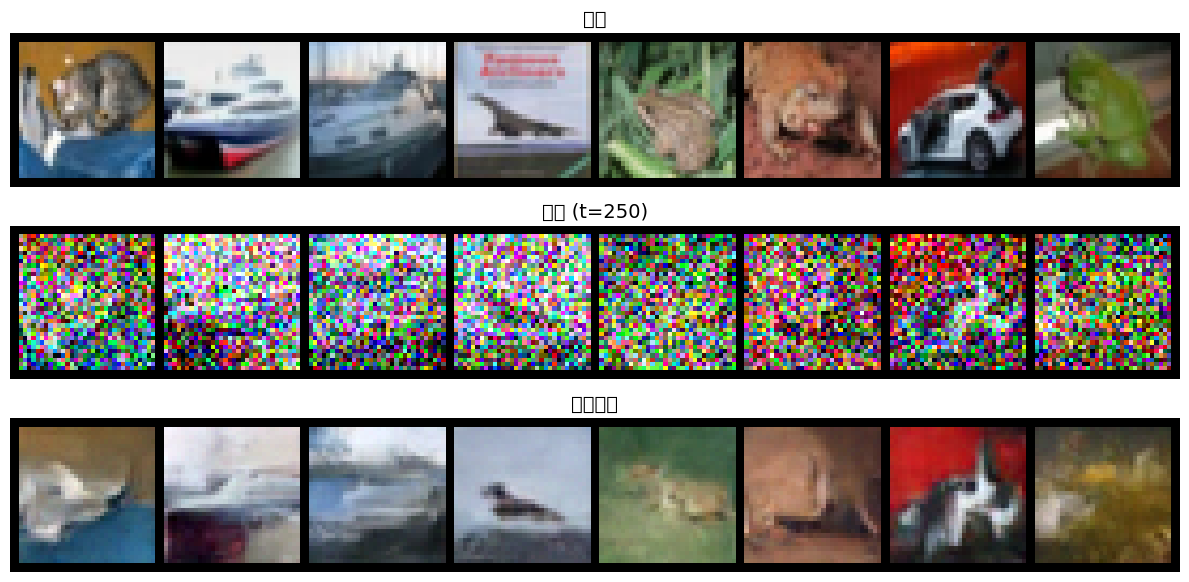

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from datasets import load_dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# =============================
# 1. 环境与预处理
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

normalize_mean = (0.5, 0.5, 0.5)
normalize_std = (0.5, 0.5, 0.5)

img_transform = transforms.Compose([
    transforms.Lambda(lambda img: Image.fromarray(img) if isinstance(img, np.ndarray) else img),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(normalize_mean, normalize_std),
])

# =============================
# 2. CIFAR-10 数据加载
# =============================
class CIFAR10Dataset(Dataset):
    def __init__(self, dataset, transforms=None):
        self.dataset = dataset
        self.transforms = transforms
        self.label_map = sorted(list(set([d["label"] for d in dataset])))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        image = data["img"] if "img" in data else data["image"]
        label = data["label"]
        if self.transforms:
            image = self.transforms(image)
        return image, torch.tensor(label, dtype=torch.long)

# 使用 parquet 数据路径加载
train_raw = load_dataset("/cifar10", split="train")
val_raw = load_dataset("/cifar10", split="test")

train_dataset = CIFAR10Dataset(train_raw, transforms=img_transform)
val_dataset = CIFAR10Dataset(val_raw, transforms=img_transform)

# =============================
# 3. 加载模型和调度器
# =============================
from diffusers import UNet2DModel, DDPMScheduler

model = UNet2DModel(
    sample_size=32,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(32, 64, 128, 256),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
).to(device)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

model.load_state_dict(torch.load("/checkpoints_finetune_cifar10/best_model.pt", map_location="cpu"))

# === 加载训练好的权重 ===
model.load_state_dict(torch.load("tinyimagenet_ddpm_32/best_model.pt", map_location="cpu"))
model = model.to(device)
model.eval()
print("✅ 模型已成功加载（来自 Tiny-ImageNet 训练）。")

# =============================
# 4. 推理过程
# =============================
T = 250  # ✅ 扩散步数，可调
cols = ["原图", f"加噪 (t={T})", "反向还原"]

# 从 CIFAR-10 测试集中选取 8 张图片
num_samples = 8
samples = [val_dataset[i][0] for i in range(num_samples)]
x0 = torch.stack(samples).to(device)

# === 加噪 ===
t = torch.tensor([T] * num_samples, device=device)
noise = torch.randn_like(x0)
noisy = noise_scheduler.add_noise(x0, noise, t)

# === 反向去噪 ===
x = noisy.clone()
with torch.no_grad():
    for step in range(T, 0, -1):
        t_step = torch.full((num_samples,), step, device=device, dtype=torch.long)
        noise_pred = model(x, t_step).sample
        x = noise_scheduler.step(noise_pred, int(step), x).prev_sample  # ✅ 关键修改


# === 转换为图像 ===
def to_img(x):
    x = (x.clamp(-1, 1) + 1) / 2
    return x

x0_vis = to_img(x0).cpu()
noisy_vis = to_img(noisy).cpu()
x_recon_vis = to_img(x).cpu()

# === 绘图展示 ===
fig, axes = plt.subplots(3, 1, figsize=(12, 6))
images = [x0_vis, noisy_vis, x_recon_vis]

for ax, imgs, title in zip(axes, images, cols):
    grid = make_grid(imgs, nrow=num_samples)
    ax.imshow(grid.permute(1, 2, 0))
    ax.axis("off")
    ax.set_title(title, fontsize=14)

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from datasets import load_dataset
from PIL import Image
import numpy as np
from torchvision.utils import make_grid, save_image
import os
from diffusers import UNet2DModel, DDPMScheduler
from tqdm import tqdm

# =============================
# 1. 环境与预处理
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

normalize_mean = (0.5, 0.5, 0.5)
normalize_std = (0.5, 0.5, 0.5)

img_transform = transforms.Compose([
    transforms.Lambda(lambda img: Image.fromarray(img) if isinstance(img, np.ndarray) else img),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(normalize_mean, normalize_std),
])

# =============================
# 2. CIFAR-10 数据加载（替换为本地MNIST）
# =============================
class CIFAR10Dataset(Dataset):
    def __init__(self, dataset, transforms=None):
        self.dataset = dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        image = data["img"] if "img" in data else data["image"]

        # 自动识别标签字段
        if "fine_label" in data:
            label = data["fine_label"]
        elif "label" in data:
            label = data["label"]
        else:
            raise KeyError("Dataset sample does not contain 'label' or 'fine_label'")

        if self.transforms:
            image = self.transforms(image)

        return image, torch.tensor(label, dtype=torch.long)


train_raw = load_dataset("/cifar100", split="train")
val_raw = load_dataset("/cifar100", split="test")
val_dataset = CIFAR10Dataset(val_raw, transforms=img_transform)

# =============================
# 3. 加载两个模型
# =============================
def load_unet_model(weight_path):
    model = UNet2DModel(
        sample_size=32,
        in_channels=3,
        out_channels=3,
        layers_per_block=2,
        block_out_channels=(32, 64, 128, 256),
        down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
        up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    ).to(device)
    model.load_state_dict(torch.load(weight_path, map_location="cpu"))
    model.eval()
    return model

model_cifar10 = load_unet_model("/checkpoints_finetune_cifar100/best_model.pt")
model_tiny = load_unet_model("tinyimagenet_ddpm_32/best_model.pt")
print("✅ 两个模型均已加载完成")

# =============================
# 4. 推理准备
# =============================
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
T = 250
num_samples = 18
samples = [val_dataset[i][0] for i in range(num_samples)]
x0 = torch.stack(samples).to(device)

# 随机选定加噪步
t = torch.tensor([T] * num_samples, device=device)
noise = torch.randn_like(x0)
noisy = noise_scheduler.add_noise(x0, noise, t)

# =============================
# 5. 对同一加噪图反向还原（两个模型）
# =============================
def reverse_denoise(model, noisy, T):
    x = noisy.clone()
    with torch.no_grad():
        for step in tqdm(range(T, 0, -1), desc="反向扩散中"):
            t_step = torch.full((noisy.size(0),), step, device=device, dtype=torch.long)
            noise_pred = model(x, t_step).sample
            x = noise_scheduler.step(noise_pred, int(step), x).prev_sample
    return x

recon_cifar10 = reverse_denoise(model_cifar10, noisy, T)
recon_tiny = reverse_denoise(model_tiny, noisy, T)

# =============================
# 6. 保存结果（单独图 + 拼接图）
# =============================
save_dir = "recon_results/cifar100"
os.makedirs(save_dir, exist_ok=True)

def to_img(x):  # [-1,1] -> [0,1]
    return (x.clamp(-1, 1) + 1) / 2

x0_vis = to_img(x0).cpu()
noisy_vis = to_img(noisy).cpu()
recon_cifar10_vis = to_img(recon_cifar10).cpu()
recon_tiny_vis = to_img(recon_tiny).cpu()

# --- 单张保存 ---
for i in range(num_samples):
    save_image(x0_vis[i], os.path.join(save_dir, f"sample_{i:02d}_original.png"))
    save_image(noisy_vis[i], os.path.join(save_dir, f"sample_{i:02d}_noisy.png"))
    save_image(recon_cifar10_vis[i], os.path.join(save_dir, f"sample_{i:02d}_recon.png"))
    save_image(recon_tiny_vis[i], os.path.join(save_dir, f"sample_{i:02d}_recon_pretrain.png"))

# --- 拼接保存（每9张一组，共2组） ---
def save_grid(imgs, name_prefix, nrow=3):
    total = imgs.size(0)
    num_groups = (total + 8) // 9  # 每9张一组
    for g in range(num_groups):
        start = g * 9
        end = min(start + 9, total)
        grid = make_grid(imgs[start:end], nrow=nrow, padding=2)
        save_image(grid, os.path.join(save_dir, f"{name_prefix}_part{g+1}.png"))

save_grid(x0_vis, "grid_original")
save_grid(noisy_vis, f"grid_noisy_t{T}")
save_grid(recon_cifar10_vis, "grid_recon")
save_grid(recon_tiny_vis, "grid_recon_pretrain")

print(f"✅ 已保存单张图与两组3×3拼接图到：{save_dir}")



✅ 两个模型均已加载完成


反向扩散中: 100%|██████████| 250/250 [00:03<00:00, 72.79it/s]

✅ 已保存单张图与3×3拼接图到：recon_results/cifar100


In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from datasets import load_dataset
from tqdm import tqdm
import numpy as np
from PIL import Image
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Diffusion parameters ===
n_steps = 1000
beta = torch.linspace(0.0001, 0.04, n_steps).to(device)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

def q_xt_x0(x0, t):
    n, c, h, w = x0.shape
    eps = torch.randn(n, c, h, w).to(device)
    a_bar = alpha_bar[t].reshape(n, 1, 1, 1)
    noisy = a_bar.sqrt() * x0 + (1 - a_bar).sqrt() * eps
    return noisy, eps

# === Dataset and transforms ===
my_transforms = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

class UserTinyImageNetDataset(Dataset):
    def __init__(self, dataset, indices, transforms=None):
        self.dataset = dataset
        self.indices = indices
        self.transforms = transforms

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image = self.dataset[self.indices[idx]]['image']
        if self.transforms:
            image = self.transforms(image)
        return image

# === Non-IID split ===
def create_non_iid_splits(dataset, num_users, alpha=0.5):
    labels = np.array([dataset[i]['label'] for i in range(len(dataset))])
    n_classes = np.max(labels) + 1
    user_indices = {i: [] for i in range(num_users)}
    class_indices = [np.where(labels == y)[0] for y in range(n_classes)]

    for idx_list in class_indices:
        np.random.shuffle(idx_list)
        proportions = np.random.dirichlet(np.repeat(alpha, num_users))
        proportions = (np.cumsum(proportions) * len(idx_list)).astype(int)
        splits = [idx_list[proportions[i-1] if i > 0 else 0: proportions[i]] for i in range(num_users)]
        for user, split in enumerate(splits):
            user_indices[user].extend(split.tolist())
    return user_indices

# === 加载 TinyImageNet 训练集 ===
num_users = 10
dir_alpha = 0.1
user_data_idx = create_non_iid_splits(train_dataset, num_users, dir_alpha)

# === 加载模型 ===
save_path = "/temp_results/tinyimagenet_fedavg_dir0.1_n_steps1000.pt"

global_model = UNet(n_channels=64).to(device)  # ⚠️ 确保定义了同样的 UNet 类
global_model.load_state_dict(torch.load(save_path, map_location=device))
global_model.eval()
print("✅ 模型已加载，开始测试...")

# === 测试模型 ===
batch_size = 128
total_loss = 0
total_samples = 0

with torch.no_grad():
    for user in range(num_users):
        user_dataset = UserTinyImageNetDataset(train_dataset, user_data_idx[user], transforms=my_transforms)
        loader = DataLoader(user_dataset, batch_size=batch_size)
        for x0 in tqdm(loader, desc=f"Testing User {user}"):
            x0 = x0.to(device)
            t = torch.randint(0, n_steps, (x0.shape[0],), dtype=torch.long).to(device)
            xt, noise = q_xt_x0(x0, t)
            pred_noise = global_model(xt.float(), t)
            loss = F.mse_loss(noise.float(), pred_noise)
            total_loss += loss.item() * x0.size(0)
            total_samples += x0.size(0)

avg_loss = total_loss / total_samples
acc = 1 - avg_loss
print(f"\n📊 Average global performance: acc={acc:.4f} (1-MSE)")


✅ 模型已加载，开始测试...


Testing User 9: 100%|██████████| 66/66 [00:10<00:00,  6.31it/s]


📊 Average global performance: acc=0.9817 (1-MSE)


100 step
📊 Average global performance: acc=0.9456 (1-MSE)
